# The Good, the Bad, and the Ugly
## An analysis of apostle, celebrity, and politician twitter data

First, importing relevant packages at the beginning

In [2]:
import tweepy, pandas as pd, numpy as np, json, re, seaborn as sns
from textblob import TextBlob

Setting up twitter API authentication

In [4]:
consumer_key = 'sW0oAfGFGSWUHbOGv5JhvpCiW'
consumer_secret = 'V6lRbVNA7WKhOu71Io5QyHAr0x0GazuHDNDkykaAeuJjxbNSea'
access_token = '250349566-Q5lBnCb2TQwUGrroNVQgJ2HHkkZPxgyBJQWZYLWM'
access_token_secret = 'NjoCJw62fcxh2t8JFQmA6jxuwLLE6904o6ETOgq02MlzY'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)


Creating a dataframe for tweets and metadata for each public figure. Essentially I use the user_timeline api to grab 200 tweets, turn that into a dataframe, and then add metadata as columns.

In [26]:
users = ["OaksDallinH", "UchtdorfDF", "KingJames", "johntravoltahot", "kevinbacon", "KimKardashian", "officialjaden", 
         "EyringHB", "BednarDavidA", "NelsonRussellM", "SpeakerPelosi", "realDonaldTrump", "RepBenMcAdams", 
         "KremlinRussia_E", "HillaryClinton"]
tweetdata = dict()
tweetdfs = dict()
for x in users:
    tweetdata[x]= api.user_timeline(screen_name=x, count=200)
    tweetdfs[x] = pd.DataFrame(data=[tweet.text for tweet in tweetdata[x]], columns=['Tweets'])
    tweetdfs[x]['name'] = np.array([tweet.author.name for tweet in tweetdata[x]])
    tweetdfs[x]['followers'] = np.array([tweet.author.followers_count for tweet in tweetdata[x]])
    tweetdfs[x]['Date'] = np.array([tweet.created_at for tweet in tweetdata[x]])
    tweetdfs[x]['Likes'] = np.array([tweet.favorite_count for tweet in tweetdata[x]])
    tweetdfs[x]['Retweets'] = np.array([tweet.retweet_count for tweet in tweetdata[x]])
    tweetdfs[x]['length'] = np.array([len(tweet.text) for tweet in tweetdata[x]])


Next I use some "data wrangling" to put them all into one big dataframe

In [244]:
bigtweetframe = pd.concat([tweetdfs["NelsonRussellM"],tweetdfs["KingJames"], tweetdfs["OaksDallinH"], tweetdfs["UchtdorfDF"],
                          tweetdfs["johntravoltahot"], tweetdfs["kevinbacon"], tweetdfs["KimKardashian"],
                           tweetdfs["officialjaden"], tweetdfs["EyringHB"], tweetdfs["BednarDavidA"], 
                           tweetdfs["SpeakerPelosi"], tweetdfs["realDonaldTrump"], tweetdfs["RepBenMcAdams"], 
                           tweetdfs["KremlinRussia_E"], tweetdfs["HillaryClinton"]])

From the tweet text, I use some code I found at https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python- to clean the text from strange characters and then run it through algorithms that score the "polarity" and "subjectivity" of each tweet

In [245]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment_polarity(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    return analysis.sentiment.polarity 

def analize_sentiment_subjectivity(tweet):
    '''
    Utility function to classify the subjectivity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    return analysis.sentiment.subjectivity 

In [246]:
bigtweetframe['positivity'] = np.array([ analize_sentiment_polarity(tweet) for tweet in bigtweetframe['Tweets'] ])
bigtweetframe['subjectivity'] = np.array([ analize_sentiment_subjectivity(tweet) for tweet in bigtweetframe['Tweets'] ])

Next I create a variable that distinguishes between Apostles, Celebrities, and Politicians

In [247]:
bigtweetframe['category'] = bigtweetframe['name'].replace(["Russell M. Nelson", "David A. Bednar", "Henry B. Eyring",
                                                           "Dallin H. Oaks", "Dieter F. Uchtdorf"], "Apostle")
bigtweetframe['category2'] = bigtweetframe['category'].replace(['John Travolta', 'Kevin Bacon',
'Kim Kardashian West', 'Jaden Smith', 'LeBron James'], "Celeb")

bigtweetframe['Category'] = bigtweetframe['category2'].replace(['Nancy Pelosi',
       'Donald J. Trump', 'Rep. Ben McAdams', 'President of Russia', 'Hillary Clinton'], "Politician")

bigtweetframe = bigtweetframe.drop(columns=['category','category2'])

Now, let's take a look at the data to see what needs to be cleaned. First, some summary statistics

In [186]:
bigtweetframe.describe()

,followers,Likes,Retweets,length,positivity,subjectivity,logretweets,loglikes
count,2.576000e+03,2576.000000,2576.000000,2576.000000,2576.000000,2576.000000,2576.000000,2576.000000
mean,1.518734e+07,15254.404891,3941.640528,108.471661,0.135082,0.319568,5.769737,6.083177
std,2.217978e+07,36675.628493,9656.792962,40.011716,0.263885,0.320181,2.810645,3.881193
min,8.939000e+03,0.000000,0.000000,1.000000,-1.000000,0.000000,-0.105361,-0.105361
25%,1.752220e+05,10.000000,88.000000,80.000000,0.000000,0.000000,4.487512,2.388763
50%,6.905690e+05,1204.500000,371.000000,132.000000,0.000000,0.288889,5.918625,7.094567
75%,2.402127e+07,8459.000000,2343.500000,140.000000,0.267938,0.550833,7.759783,9.043092
max,5.948987e+07,446956.000000,184055.000000,155.000000,1.000000,1.000000,12.122995,13.010217


### Data Cleaning Overall
There do not seem to be many unusual values, mostly just large ones that are possible for people with millions of followers. The few exceptions are length: tweets should normally be only 140 characters. We'll look into that later, but next we'll go to each variable and examine it further. 
##### Missing values 
Also not an issue: each variable has 2,576 observations.
### Examining variable by variable for outliers or normality
#### Followers
Everyone here has a lot of followers, but they are orders of magnitude different. This variable should only have 15 unique values and is constant for each public figure so it can't be used at the "tweet" level. We'll look at the unique values though.

In [189]:
bigtweetframe['followers'].unique()

array([  145448, 42066710,   175222,   278318,    10339,   653705,
       59489874,  8014462,   170556,   234937,  2152447, 57870675,
           8939,   690569, 24021266], dtype=int64)

A few with around 10k-70k, others with 8, 24, 59 million. That's a lot!

#### Likes 
Likes also vary a lot. There are some with zero likes, and many of those are a little different: the user doesn't get credit when there is a retweet. Though this assignment's scope is limited, it would be beneficial in the future to distinguish those tweets that are retweets and others. If we look at the distribution, it is definitely not normal. We can log-transfor likes to make it normal, and potentially more usable, as shown by the second graph. This is an alternative approach to dealing with outliers. However, this is looking at all data: if we want to use likes for an individual public figure we may want to look at their specific distribution

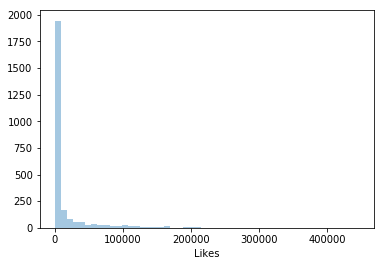

In [94]:
sns.distplot(bigtweetframe['Likes'], kde=False)

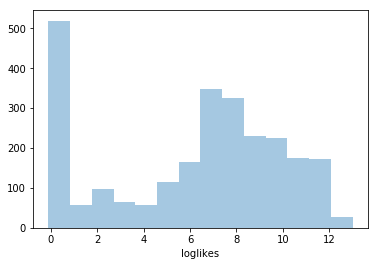

In [250]:
bigtweetframe['loglikes'] = np.log(bigtweetframe['Likes']+.9)
sns.distplot(bigtweetframe['loglikes'], kde=False)

#### Retweets
Retweets are also really skewed. Unlike likes, a user is credited when someone retweets a tweet that they retweeted, so zeros really mean no one retweeted it. Log transformation seems to also fix retweets, though it is thrown off slightly by the 5% or so of tweets that were not retweeted.

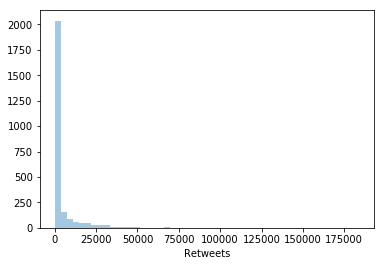

In [176]:
sns.distplot(bigtweetframe['Retweets'], kde=False)

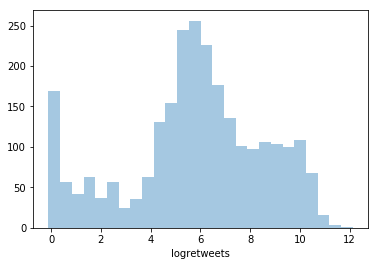

In [251]:
bigtweetframe['logretweets'] = np.log(bigtweetframe['Retweets']+.9)
sns.distplot(bigtweetframe['logretweets'], kde=False)

#### Subjectivitiy
This variable is the algorithms rating of how "subjective" the tweet is. Many tweets receive a subjectivity rating of 0, with 1 as the largest value.

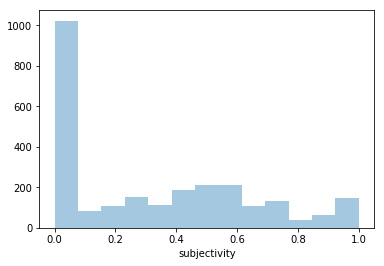

In [248]:
sns.distplot(bigtweetframe['subjectivity'], kde=False)

We can look at whether there are any extreme values in subjectivity. It looks like for a value to be extreme it would have to be above 1.4 or below -.8. These don't exist in our data, so we don't need to worry about outliers for positivity.

In [199]:
a=bigtweetframe['subjectivity']
subj_upbound=2*(a.quantile(.75)-a.quantile(.25))+a.quantile(.50)
subj_lowbound=-2*(a.quantile(.75)-a.quantile(.25))+a.quantile(.50)
print(subj_upbound, subj_lowbound)





1.3905555555555558 -0.8127777777777778


#### Positivity
A very interesting variable from this dataset looks at how positive or negative the sentiment from the tweet was, as determined by the algorithm. Looks like very many tweets received a positivity score of zero. What is up in these case?

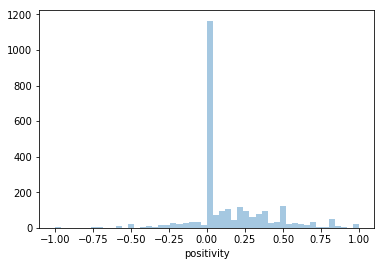

In [95]:
sns.distplot(bigtweetframe['positivity'], kde=False)


In [231]:
bigtweetframe[['Tweets', 'name']][bigtweetframe.positivity==0].sample(10)

,Tweets,name
70,Never seen @senatemajldr and Republicans so united on an issue as they are on the Humanitarian Crisis &amp; Security on… https://t.co/aHShFrWjHN,Donald J. Trump
25,"Our Savior, Jesus Christ, knows each of us by name. I witness and promise we can not only know about the Lord but a… https://t.co/6cZecZ7QHj",David A. Bednar
160,((VISION)) 3x?,Jaden Smith
69,@realDonaldTrump The truth? Republicans started the #TrumpShutdown — and Democrats are working to end it.… https://t.co/sg7u48dbsr,Nancy Pelosi
110,"See where I come from/We had to beat the streets/Beat the system, beat racism, beat poverty/And now we made it thro… https://t.co/GFHlmbtyQ2",LeBron James
139,"The final margin in the race for Senate in Florida is too close to call, and the Secretary of State has just ordere… https://t.co/G3SRaWw0f4",Hillary Clinton
123,Ciara Minaj Carter. \nNikki Janelle Enriquez. \nLondonn Moore. \nShantee Tucker. \nDejanay Stanton. \nVontashia Bell. \nS… https://t.co/gm6WO6lpmQ,Hillary Clinton
53,Kyra Sedgwick Launches Big Swing Productions; Unveils TV &amp; Film Slate | Deadline yeah baby! https://t.co/KFFoBFZJtK,Kevin Bacon
110,Coming soon... https://t.co/rrxN4B4Vj1,Kim Kardashian West
160,My 2 faves!!! https://t.co/0LfMVk5koZ,Kim Kardashian West


Though some of these have truly neutral text (e.g. "Coming soon..."), others are not just plain. There doesn't seem to be a justification to chuck 0's out, though it is worth examining. <br>
Next let's look at potential outliers

In [249]:
a=bigtweetframe['positivity']
pos_upbound=2*(a.quantile(.75)-a.quantile(.25))+a.quantile(.50)
pos_lowbound=-2*(a.quantile(.75)-a.quantile(.25))+a.quantile(.50)
print("top and bottwom whiskers:", pos_upbound, pos_lowbound)

top and bottwom whiskers: 0.5358766233766235 -0.5358766233766235


In [235]:
a=bigtweetframe['positivity'].replace(0,np.NaN)
pos_upbound=2*(a.quantile(.75)-a.quantile(.25))+a.quantile(.50)
pos_lowbound=-2*(a.quantile(.75)-a.quantile(.25))+a.quantile(.50)
print("top and bottom whiskers excluding 0's", pos_upbound, pos_lowbound)

top and bottom whiskers excluding 0's 0.966919191919192 -0.46691919191919196


Looks like whether or not we exclude 0's, there are values that are well outside the whisker plots. Examining the content of really positive and really negative sentiments, it seems that the most negative are not always quite so bad, just that there isn't any other content. The same might be said of the most positive. It is probably worthwhile to create a truncated variable with fenced outliers.

In [224]:
pd.options.display.max_colwidth = 200
bigtweetframe[['Tweets','name',]][bigtweetframe.positivity==1].head(10)

,Tweets,name
12,"I promise that if we will do our best to restore the correct name of the Lord’s Church, He whose Church this is wil… https://t.co/sQdwKhNOup",Russell M. Nelson
54,“A book is meant to be read from beginning to end but it’s best understood from end to beginning”- Mr. Church 📖,LeBron James
53,"God knows your every thought, your sorrows, and your greatest hopes. \n\nNo matter your history—if you have faltered,… https://t.co/8TS5gkJkNs",Dieter F. Uchtdorf
90,God’s greatest reward goes to those who serve without expectation of reward.,Dieter F. Uchtdorf
158,Our perfect Father in Heaven opens the windows of heaven and pours out a blessing to those who incline their hearts to Him and serve others.,Dieter F. Uchtdorf
188,Today I was blessed to participate in the Phoenix Arizona Temple dedication. How wonderful the Lord's temples are. http://t.co/fXv02C9O8u,Dieter F. Uchtdorf
47,Hope everyone is having a wonderful Easter. I'M HUNGRY. :),John Travolta
95,RT @SixDegreesofKB: This is awesome @ricky_martin! Your commitment to building 100 homes for families in #PuertoRico is an inspiration! Rea…,Kevin Bacon
131,The best!!! https://t.co/LsKZdFp8BO,Kim Kardashian West
189,I hope you have the best birthday 💋 https://t.co/DiwTU7faTi,Kim Kardashian West


In [230]:
pd.options.display.max_colwidth = 200
bigtweetframe[['Tweets','name',]][bigtweetframe.positivity==-1]

,Tweets,name
52,Nasty!! https://t.co/xkmg3fsHOi,LeBron James
47,Immersing ourselves in the words of the Lord’s chosen servants can protect us from evil. I invite you to do so this weekend at #LDSconf.,Henry B. Eyring
67,RT @RepDianaDeGette: Stories like Mallory’s reveal the terrifying reality of this shutdown. Furloughed workers are facing life-or-death sit…,Nancy Pelosi
166,We won’t let the GOP’s cruel lawsuit stop Americans from getting affordable health care.\n\nRemember: today is the de… https://t.co/qVR6K3HHb5,Nancy Pelosi


In [254]:
bigtweetframe['fenced_positivity']=bigtweetframe['positivity']
bigtweetframe['fenced_positivity'].loc[bigtweetframe['fenced_positivity']<=-.53]=-.53
bigtweetframe['fenced_positivity'].loc[bigtweetframe['fenced_positivity']>=.53]=.53

In [282]:
bigtweetframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2576 entries, 0 to 199
Data columns (total 13 columns):
Tweets               2576 non-null object
name                 2576 non-null object
followers            2576 non-null int32
Date                 2576 non-null datetime64[ns]
Likes                2576 non-null int32
Retweets             2576 non-null int32
length               2576 non-null int32
positivity           2576 non-null float64
subjectivity         2576 non-null float64
Category             2576 non-null object
loglikes             2576 non-null float64
logretweets          2576 non-null float64
fenced_positivity    2576 non-null float64
dtypes: datetime64[ns](1), float64(5), int32(4), object(3)
memory usage: 321.5+ KB


Looks like there is a variable or two that should be categorical. The name variable would messy our dataframe if we tried to create a dummy variable; let's try the Category variable though

In [287]:
dummy_df = pd.get_dummies(bigtweetframe['Category']) # creating a dataframe with dummy variables
bigtweetframe = pd.concat([bigtweetframe, dummy_df], axis=1) # merging it with the regular frame


In [317]:
bigtweetframe.describe().round(2)

,followers,Likes,Retweets,length,positivity,subjectivity,loglikes,logretweets,fenced_positivity,Apostle,Celeb,Politician
count,2576.00,2576.00,2576.00,2576.00,2576.00,2576.00,2576.00,2576.00,2576.00,2576.00,2576.00,2576.00
mean,15187337.85,15254.40,3941.64,108.47,0.14,0.32,6.08,5.77,0.12,0.23,0.38,0.39
std,22179782.06,36675.63,9656.79,40.01,0.26,0.32,3.88,2.81,0.22,0.42,0.49,0.49
min,8939.00,0.00,0.00,1.00,-1.00,0.00,-0.11,-0.11,-0.53,0.00,0.00,0.00
25%,175222.00,10.00,88.00,80.00,0.00,0.00,2.39,4.49,0.00,0.00,0.00,0.00
50%,690569.00,1204.50,371.00,132.00,0.00,0.29,7.09,5.92,0.00,0.00,0.00,0.00
75%,24021266.00,8459.00,2343.50,140.00,0.27,0.55,9.04,7.76,0.27,0.00,1.00,1.00
max,59489874.00,446956.00,184055.00,155.00,1.00,1.00,13.01,12.12,0.53,1.00,1.00,1.00


In [320]:
bigtweetframe['name'].value_counts()

Nancy Pelosi           200
Rep. Ben McAdams       200
Kevin Bacon            200
Donald J. Trump        200
LeBron James           200
Hillary Clinton        200
Jaden Smith            200
Kim Kardashian West    200
President of Russia    200
Dieter F. Uchtdorf     197
John Travolta          179
Henry B. Eyring        131
Russell M. Nelson      106
David A. Bednar         98
Dallin H. Oaks          65
Name: name, dtype: int64

In [318]:
bigtweetframe.groupby(by="Category")[["Likes", "Retweets","fenced_positivity","positivity","subjectivity"]].mean().round(2)

,Likes,Retweets,fenced_positivity,positivity,subjectivity
Category,,,,,
Apostle,2045.53,433.99,0.19,0.21,0.40
Celeb,13246.53,2689.13,0.11,0.13,0.29
Politician,25105.81,7261.92,0.09,0.10,0.30


In [316]:
bigtweetframe.groupby(by="name")[["followers","Likes", "Retweets","fenced_positivity","positivity","subjectivity"]].mean().round(2)

,followers,Likes,Retweets,fenced_positivity,positivity,subjectivity
name,,,,,,
Dallin H. Oaks,175222.0,1465.09,322.51,0.15,0.16,0.37
David A. Bednar,234937.0,1600.26,363.43,0.17,0.18,0.40
Dieter F. Uchtdorf,278318.0,2539.63,569.84,0.22,0.24,0.46
Donald J. Trump,57870675.0,85203.94,24763.91,0.09,0.09,0.40
Henry B. Eyring,170556.0,1513.83,316.02,0.19,0.21,0.39
Hillary Clinton,24021266.0,19856.40,5143.20,0.13,0.14,0.36
Jaden Smith,8014462.0,9337.42,1891.50,0.05,0.06,0.19
John Travolta,10339.0,10.34,2.73,0.11,0.12,0.38
Kevin Bacon,653705.0,722.33,3121.14,0.14,0.17,0.33


#### Does positivity predict retweets and likes
This is examined individually: you would need to control for fixed effects to examine the collective relationship (most of the variance is explained by those who have really large followings). However, it looks like most correlations between positivity and likes are very small. The distribution is probably not much different than would be expected by chance

In [315]:
bigtweetframe.groupby(by="name")["loglikes","logretweets","fenced_positivity"].corr()
#bigtweetframe.replace(0,np.NaN).groupby(by="name")["Likes","fenced_positivity"].corr() #this removes likely retweets (where the user cannot get credit for likes)

Likes  fenced_positivity
name                                                              
Dallin H. Oaks      Likes              1.000000          -0.132168
                    fenced_positivity -0.132168           1.000000
David A. Bednar     Likes              1.000000           0.027114
                    fenced_positivity  0.027114           1.000000
Dieter F. Uchtdorf  Likes              1.000000          -0.054087
                    fenced_positivity -0.054087           1.000000
Donald J. Trump     Likes              1.000000          -0.035765
                    fenced_positivity -0.035765           1.000000
Henry B. Eyring     Likes              1.000000          -0.005794
                    fenced_positivity -0.005794           1.000000
Hillary Clinton     Likes              1.000000           0.070614
                    fenced_positivity  0.070614           1.000000
Jaden Smith         Likes              1.000000           0.038762
                    fenced_positivity  0.038762           1.000000
John Travolta       Likes              1.000000          -0.057944
                    fenced_positivity -0.057944           1.000000
Kevin Bacon         Likes              1.000000           0.020461
                    fenced_positivity  0.020461           1.000000
Kim Kardashian West Likes              1.000000           0.235761
                    fenced_positivity  0.235761           1.000000
LeBron James        Likes              1.000000          -0.136463
                    fenced_positivity -0.136463           1.000000
Nancy Pelosi        Likes              1.000000          -0.005070
                    fenced_positivity -0.005070           1.000000
President of Russia Likes              1.000000           0.155036
                    fenced_positivity  0.155036           1.000000
Rep. Ben McAdams    Likes              1.000000          -0.043564
                    fenced_positivity -0.043564           1.000000
Russell M. Nelson   Likes              1.000000          -0.094291
                    fenced_positivity -0.094291           1.000000

### Main Illustration
The cell below shows a bar chart comparing the positivity of tweets from apostles, celebrities, and politicians. The black line denotes significant bands. This means that when it does not overlap with another bar, that group is statistically different. The commented out barplots were checked for robustness. Results stay the same regardless.

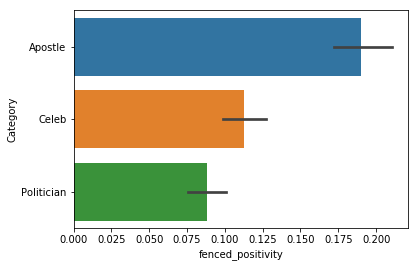

In [341]:
sns.barplot(bigtweetframe['fenced_positivity'],bigtweetframe['Category'])
#sns.barplot(bigtweetframe['fenced_positivity'].replace(0,np.NaN),bigtweetframe['Category'])
#sns.barplot(bigtweetframe['positiity'],bigtweetframe['Category'])
#sns.barplot(bigtweetframe['positivity'].replace(0,np.NaN),bigtweetframe['Category'])

#### Looking individuals at more specifically

Elder Uchtdorf is the most positive. He is significantly more positive than everyone except Eyring and Nelson. The 5 most positive twitter accounts are all apostles (though there are not always significant differences)

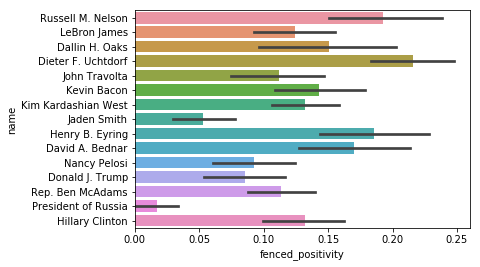

In [261]:
sns.barplot(bigtweetframe['fenced_positivity'],bigtweetframe['name'])

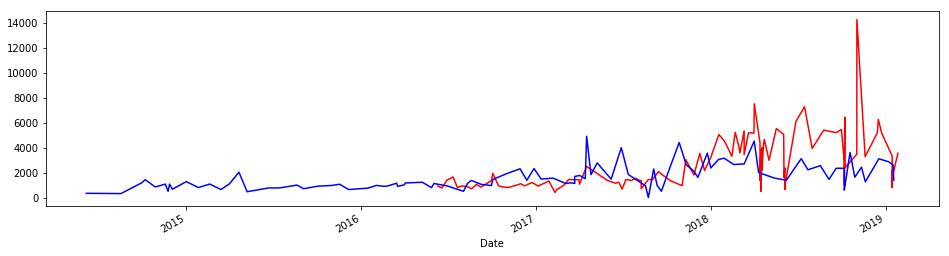

In [332]:
tlikes = pd.Series(data=bigtweetframe['Likes'][bigtweetframe.name=="Russell M. Nelson"].values, 
                   index=bigtweetframe[bigtweetframe.name=="Russell M. Nelson"]['Date'])
tlikesb = pd.Series(data=bigtweetframe['Likes'][bigtweetframe.name=="David A. Bednar"].values, 
                   index=bigtweetframe[bigtweetframe.name=="David A. Bednar"]['Date'])
tlikes.plot(figsize=(16,4), color='r')
tlikesb.plot(figsize=(16,4), color='b')

Above compares the likes received by Elder Bednar's Tweets (blue) with President Nelson's (Red). They are mostly parallel until 2018, when President Nelson was called as prophet.

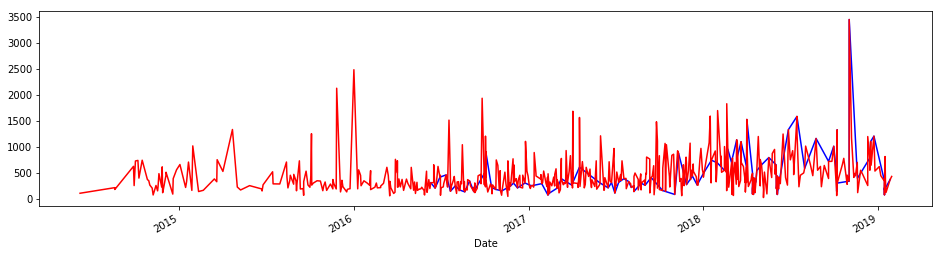

In [338]:
tlikes = pd.Series(data=bigtweetframe['Retweets'][bigtweetframe.name=="Russell M. Nelson"].values, 
                   index=bigtweetframe[bigtweetframe.name=="Russell M. Nelson"]['Date'])
tlikesb = pd.Series(data=bigtweetframe['Retweets'][bigtweetframe.Category=="Apostle"].values, 
                   index=bigtweetframe[bigtweetframe.Category=="Apostle"]['Date'])
tlikes.plot(figsize=(16,4), color='b')
tlikesb.plot(figsize=(16,4), color='r')

Above compares the retweets received from all the apostles (red) to the retweets received by President Nelson. When he was called as prophet (2018), he goes from below to above the rest on average.